<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/PPG_CNN_LSTM_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [36]:
# 1. MAT 로딩 함수 (PPG only)
# =========================
def load_ppg_bp_from_mat(mat_path, max_segments=2000):
    """
    mat_path: p096530.mat 같은 파일 경로
    max_segments: 앞에서 사용할 최대 세그먼트 수 (시간순)
    return:
        X_all: (N, L, 1)  PPG
        y_all: (N, 2)     [SBP, DBP]
        patient_id: 문자열 (예: 'p096530')
    """
    f = h5py.File(mat_path, "r")
    subj = f["Subj_Wins"]
    refs = f["#refs#"]

    def read_cell(obj, idx):
        ref = obj[0, idx]
        return np.array(refs[ref])

    # 전체 세그먼트 개수
    N_total = subj["PPG_F"].shape[1]

    ppg_list = []
    sbp_list = []
    dbp_list = []
    t_list   = []

    for i in range(N_total):
        # PPG: (1, L) -> (L,)
        ppg = read_cell(subj["PPG_F"], i).astype(np.float32).reshape(-1)
        ppg_list.append(ppg)

        # SBP/DBP: (1,1) -> scalar
        sbp = read_cell(subj["SegSBP"], i).astype(np.float32)[0, 0]
        dbp = read_cell(subj["SegDBP"], i).astype(np.float32)[0, 0]
        sbp_list.append(sbp)
        dbp_list.append(dbp)

        # 시간 정보 (정렬용)
        T  = read_cell(subj["T"], i).astype(np.float64)
        t_list.append(float(T[0, 0]))

    ppg_arr = np.stack(ppg_list, axis=0)
    sbp_arr = np.array(sbp_list)
    dbp_arr = np.array(dbp_list)
    t_arr   = np.array(t_list)

    # 환자 ID
    subj_id_arr = read_cell(subj["SubjectID"], 0)
    patient_id = "".join(chr(int(c)) for c in subj_id_arr.reshape(-1))

    # 시간 순 정렬
    order = np.argsort(t_arr)
    ppg_sorted = ppg_arr[order]
    sbp_sorted = sbp_arr[order]
    dbp_sorted = dbp_arr[order]

    plot_bp_full_timeseries(sbp_sorted, dbp_sorted, patient_id=patient_id)


    # 앞 max_segments만 사용
    if ppg_sorted.shape[0] < max_segments:
        raise ValueError(f"{mat_path}: 세그먼트 {max_segments}개 필요, 현재 {ppg_sorted.shape[0]}개")

    ppg_sorted = ppg_sorted[:max_segments]
    sbp_sorted = sbp_sorted[:max_segments]
    dbp_sorted = dbp_sorted[:max_segments]

    # 텐서 만들기
    X_all = ppg_sorted[..., np.newaxis]                     # (N, L, 1)
    y_all = np.stack([sbp_sorted, dbp_sorted], axis=1)      # (N, 2)

    f.close()

    print(f"{mat_path} 로드 완료. 환자: {patient_id}, 세그먼트: {X_all.shape[0]}, 길이: {X_all.shape[1]}")
    return X_all, y_all, patient_id

In [37]:
# 2. PPG CNN+LSTM 모델 정의
# =========================
def build_ppg_cnn_lstm(input_shape):
    """
    PPG only -> [SBP, DBP] 회귀
    CNN + LSTM
    input_shape: (L, 1)
    """
    inp = layers.Input(shape=input_shape)

    x = layers.Conv1D(32, 7, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 5, padding="same", activation="relu")(x)
    x = layers.MaxPooling1D(2)(x)

    x = layers.Conv1D(64, 3, padding="same", activation="relu")(x)

    x = layers.LSTM(64, return_sequences=False)(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    out = layers.Dense(2, activation="linear")(x)   # [SBP, DBP]

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="mse"
    )
    return model

In [38]:
# 3. A로 학습 → A/B에 테스트
# =========================
def train_A_and_test_on_A_and_B(mat_A, mat_B):
    """
    mat_A: A 환자 .mat 경로 (예: p096530.mat)
    mat_B: B 환자 .mat 경로 (예: p005521.mat)
    - A: 앞 1600세그 train+val, 뒤 400세그 test_A
      * train: 0~1279
      * val  : 1280~1599
    - B: 뒤 400세그(1600~1999)를 test_B로 사용
    - scaler는 A_train으로만 fit, A/B 모두 동일 스케일 사용
    """
    # ----- 데이터 로드 -----
    X_A, y_A, pid_A = load_ppg_bp_from_mat(mat_A, max_segments=2000)
    X_B, y_B, pid_B = load_ppg_bp_from_mat(mat_B, max_segments=2000)

    N, L, C = X_A.shape   # (2000, L, 1)

    # ----- 인덱스 분할 -----
    # A: 0~1599 = train+val, 1600~1999 = test_A
    idx_trainval_A = np.arange(0, 1600)
    idx_test_A     = np.arange(1600, 2000)

    # train/val 분리 (80% / 20%)
    n_train = int(0.8 * len(idx_trainval_A))    # 1280
    idx_train_A = idx_trainval_A[:n_train]
    idx_val_A   = idx_trainval_A[n_train:]

    # B: A와 같은 범위의 test 구간 (1600~1999)
    idx_test_B  = np.arange(1600, 2000)

    X_train_A = X_A[idx_train_A]
    y_train_A = y_A[idx_train_A]
    X_val_A   = X_A[idx_val_A]
    y_val_A   = y_A[idx_val_A]
    X_test_A  = X_A[idx_test_A]
    y_test_A  = y_A[idx_test_A]

    X_test_B  = X_B[idx_test_B]
    y_test_B  = y_B[idx_test_B]

    # ----- 입력 스케일링 (A_train 기준) -----
    scaler = StandardScaler()

    N_tr = X_train_A.shape[0]
    X_train_flat = X_train_A.reshape(N_tr, -1)
    X_train_scaled = scaler.fit_transform(X_train_flat).reshape(N_tr, L, C)

    N_val = X_val_A.shape[0]
    X_val_scaled = scaler.transform(X_val_A.reshape(N_val, -1)).reshape(N_val, L, C)

    N_teA = X_test_A.shape[0]
    X_test_A_scaled = scaler.transform(X_test_A.reshape(N_teA, -1)).reshape(N_teA, L, C)

    N_teB = X_test_B.shape[0]
    X_test_B_scaled = scaler.transform(X_test_B.reshape(N_teB, -1)).reshape(N_teB, L, C)

    # ----- 모델 학습 (A) -----
    model = build_ppg_cnn_lstm((L, C))

    es = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    print(f"\n[훈련] 환자 A ({pid_A}) 로 학습 시작")
    history = model.fit(
        X_train_scaled, y_train_A,
        validation_data=(X_val_scaled, y_val_A),
        epochs=100,
        batch_size=32,
        verbose=1,
        callbacks=[es]
    )

    # ----- A에 대한 평가 -----
    y_pred_A = model.predict(X_test_A_scaled)
    mae_sbp_A = mean_absolute_error(y_test_A[:, 0], y_pred_A[:, 0])
    mae_dbp_A = mean_absolute_error(y_test_A[:, 1], y_pred_A[:, 1])
    rmse_sbp_A = np.sqrt(mean_squared_error(y_test_A[:, 0], y_pred_A[:, 0]))
    rmse_dbp_A = np.sqrt(mean_squared_error(y_test_A[:, 1], y_pred_A[:, 1]))

    print(f"\n A({pid_A}) Test 결과 ")
    print(f"MAE  SBP: {mae_sbp_A:.3f}, DBP: {mae_dbp_A:.3f}")
    print(f"RMSE SBP: {rmse_sbp_A:.3f}, DBP: {rmse_dbp_A:.3f}")

    # ----- B에 대한 평가 (A로 학습한 모델 사용) -----
    y_pred_B = model.predict(X_test_B_scaled)
    mae_sbp_B = mean_absolute_error(y_test_B[:, 0], y_pred_B[:, 0])
    mae_dbp_B = mean_absolute_error(y_test_B[:, 1], y_pred_B[:, 1])
    rmse_sbp_B = np.sqrt(mean_squared_error(y_test_B[:, 0], y_pred_B[:, 0]))
    rmse_dbp_B = np.sqrt(mean_squared_error(y_test_B[:, 1], y_pred_B[:, 1]))

    print(f"\n B({pid_B}) Test 결과 ")
    print(f"MAE  SBP: {mae_sbp_B:.3f}, DBP: {mae_dbp_B:.3f}")
    print(f"RMSE SBP: {rmse_sbp_B:.3f}, DBP: {rmse_dbp_B:.3f}")

    return {
        "A_id": pid_A,
        "B_id": pid_B,
        "A_test_mae_sbp": mae_sbp_A,
        "A_test_mae_dbp": mae_dbp_A,
        "A_test_rmse_sbp": rmse_sbp_A,
        "A_test_rmse_dbp": rmse_dbp_A,
        "B_test_mae_sbp": mae_sbp_B,
        "B_test_mae_dbp": mae_dbp_B,
        "B_test_rmse_sbp": rmse_sbp_B,
        "B_test_rmse_dbp": rmse_dbp_B,
    }

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# -----------------------------------------------------
# 1) MAT 파일에서 SBP/DBP 로드 (시간순 정렬)
# -----------------------------------------------------
def load_bp_values(mat_path, max_segments=2000):
    """
    mat_path : p096530.mat 같은 환자 데이터 경로
    return : sbp_list, dbp_list (시간순 정렬)
    """

    with h5py.File(mat_path, "r") as f:
        subj = f["Subj_Wins"]
        refs = f["#refs#"]

        def read_cell(obj, idx):
            ref = obj[0, idx]
            return np.array(refs[ref])

        N_total = subj["SegSBP"].shape[1]

        sbp_list = []
        dbp_list = []
        t_list = []

        for i in range(N_total):
            sbp = read_cell(subj["SegSBP"], i)[0, 0]
            dbp = read_cell(subj["SegDBP"], i)[0, 0]
            T   = read_cell(subj["T"], i)[0, 0]

            sbp_list.append(float(sbp))
            dbp_list.append(float(dbp))
            t_list.append(float(T))

        # 시간순 정렬
        order = np.argsort(t_list)
        sbp_sorted = np.array(sbp_list)[order]
        dbp_sorted = np.array(dbp_list)[order]

        # 앞 max_segments만
        sbp_sorted = sbp_sorted[:max_segments]
        dbp_sorted = dbp_sorted[:max_segments]

    return sbp_sorted, dbp_sorted


# -----------------------------------------------------
# 2) 전 구간 SBP·DBP 변동 그래프
# -----------------------------------------------------
def plot_bp_full_timeseries(sbp, dbp, patient_id="Unknown"):
    """
    sbp, dbp : 전 구간 SBP/DBP 배열 (0~1999)
    """

    idx = np.arange(len(sbp))

    plt.figure(figsize=(16, 6))
    plt.plot(idx, sbp, color='red', linewidth=2, label='SBP')
    plt.plot(idx, dbp, color='blue', linewidth=2, label='DBP')

    # 평균선 표시
    plt.axhline(np.mean(sbp), color='darkred', linestyle='--', linewidth=1.5,
                label=f"SBP Mean: {np.mean(sbp):.1f}")
    plt.axhline(np.mean(dbp), color='darkblue', linestyle='--', linewidth=1.5,
                label=f"DBP Mean: {np.mean(dbp):.1f}")

    # SBP - DBP 영역 (Pulse Pressure)
    plt.fill_between(idx, sbp, dbp, where=(sbp > dbp),
                     color='purple', alpha=0.15, label='Pulse Pressure')

    plt.title(f"Blood Pressure Variation Over Time (Patient: {patient_id})", fontsize=15)
    plt.xlabel("Segment Index (0~1999)", fontsize=12)
    plt.ylabel("Blood Pressure (mmHg)", fontsize=12)
    plt.grid(alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


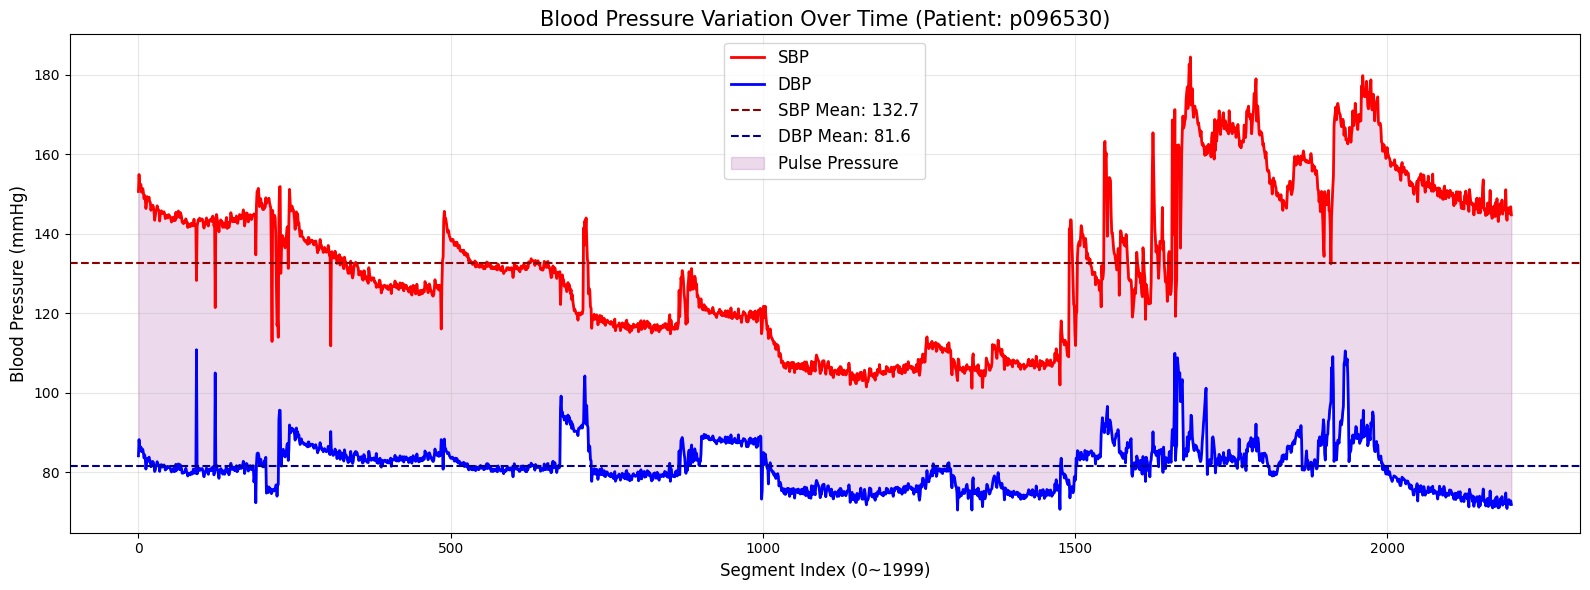

/content/drive/MyDrive/Colab Notebooks/p096530.mat 로드 완료. 환자: p096530, 세그먼트: 2000, 길이: 1250


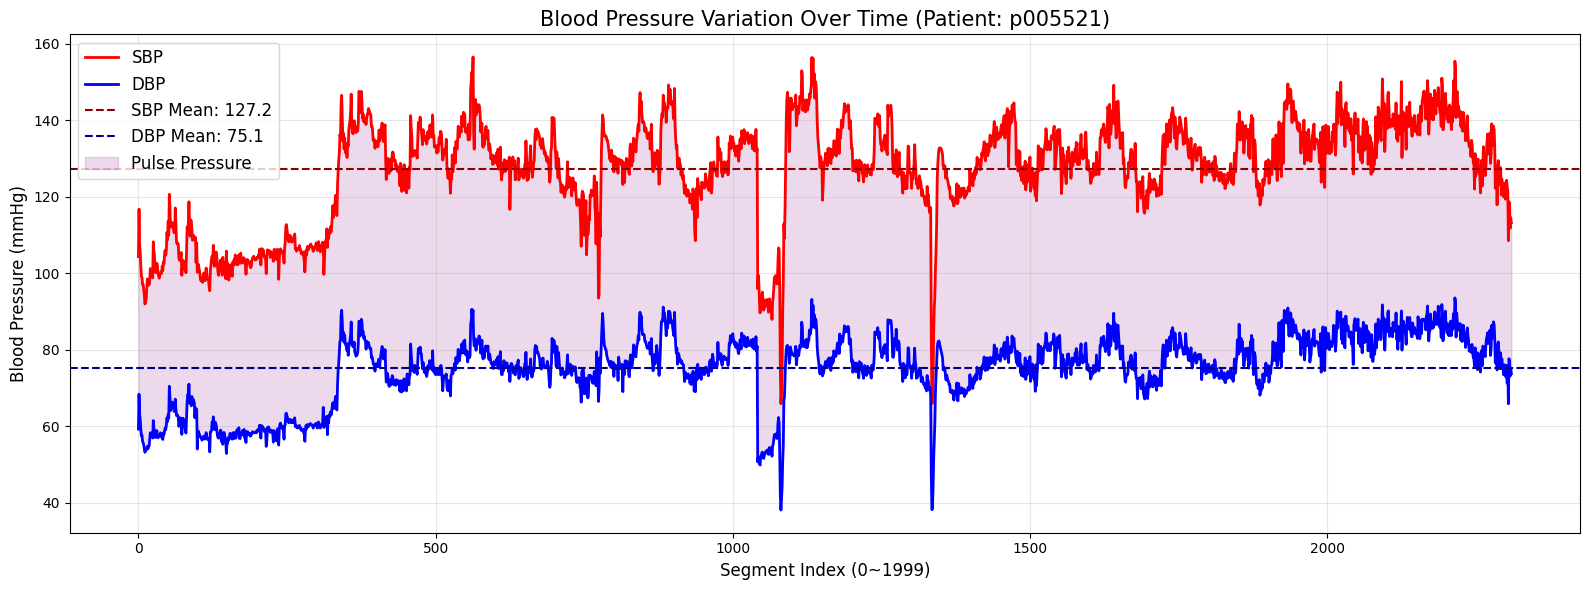

/content/drive/MyDrive/Colab Notebooks/p005521.mat 로드 완료. 환자: p005521, 세그먼트: 2000, 길이: 1250

[훈련] 환자 A (p096530) 로 학습 시작
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 10978.6719 - val_loss: 8486.8262
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 8947.3447 - val_loss: 6070.2759
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 6297.9243 - val_loss: 3401.9644
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 3547.3711 - val_loss: 1383.5769
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1619.9087 - val_loss: 424.0233
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 768.6869 - val_loss: 159.4200
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 529.1082 - val_loss: 117.0074
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 423.3453 - val_loss: 118.2051
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 450.6130 - val_loss: 120.4046
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss

In [40]:
# 4. 실행 예시
# =========================
# A = p096530, B = p005521 예시
mat_A = "/content/drive/MyDrive/Colab Notebooks/p096530.mat"
mat_B = "/content/drive/MyDrive/Colab Notebooks/p005521.mat"

results = train_A_and_test_on_A_and_B(mat_A, mat_B)